## Human ectoparasite model for Barcelona 1490

#### Import packages

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
#from pymc.Matplot import plot
import scipy.stats

#### Import observed data

In [2]:
london = np.array([2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 4, 3, 4, 5, 5, 7, 9, 10, 11, 14, 14, 17, 17, 19, 20, 20, 21, 23, 23, 25, 27, 29, 30, 32, 35, 39, 41, 45, 49, 53, 57, 63, 67, 72, 78, 84, 89, 94, 100, 105, 110, 114, 118, 122, 128, 139, 150, 165, 184, 204, 226, 246, 261, 272, 279, 282, 281, 276, 275, 276, 282, 290, 303, 319, 337, 359, 381, 405, 431, 457, 486, 514, 538, 556, 569, 575, 577, 572, 565, 563, 572, 588, 616, 651, 696, 747, 797, 842, 882, 917, 947, 974, 994, 1008, 1015, 1014, 1007, 992, 970, 943, 924, 915, 916, 927, 948, 980, 1016, 1043, 1055, 1054, 1037, 1006, 961, 904, 854, 811, 775, 749, 730, 721, 716, 714, 711, 706, 701, 696, 689, 680, 668, 651, 628, 601, 568, 531, 488, 449, 411, 376, 344, 313, 287, 261, 238, 218, 199, 182, 169, 156, 146, 139, 138, 140, 145, 155, 169, 184, 199, 206, 211, 211, 206, 197, 183, 171, 159, 148, 138, 129, 122, 114, 107, 101, 93, 86, 79, 72, 64, 57, 52, 46, 41, 38, 36, 32, 31, 30, 29, 29, 29, 31, 31, 33, 33, 35, 36, 37, 38, 38, 38, 40, 40, 41, 41, 43])
mortality_data = london
t = len(mortality_data)

#### Set up the model

In [3]:
__all__ = ['mortality_data', 'beta_1','beta_2','beta_h', 'gamma', 'sigma', 'mu', 'lice_index', 
           'E_0', 'I_0', 'R_0', 'D_0', 'D_h',
           'pop_size', 'sus_frac',
           'mortality', 'mortality_sim']

#Parameters
beta_1 = pm.Uniform('beta_1', 1e-9, .05)
beta_2 = pm.Uniform('beta_2', 1e-9, 1.)
beta_h = 0.05
sigma = 1/8.
gamma = 1/2.
mu = .6
lice_index = 15.0
pop_size = 360000.0
sus_frac = pm.Uniform('sus_frac', 1e-9, 1.)

#Initial conditions
S_0 = pop_size*sus_frac
I1_0 = pm.Uniform('I1_0', 1., 10.)
I2_0 = 2.
R_0 = 0.
D_0 = 1.

#SIIRD + vector model for human ectoparasite plague
@pm.deterministic
def SIRD(S_0=S_0, I1_0=I1_0, I2_0=I2_0, R_0=R_0, D_0=D_0, 
         beta_1=beta_1, beta_2=beta_2, beta_h=beta_h, 
         gamma=gamma, sigma=sigma, lice_index=lice_index):
    S_h = np.zeros(t)
    I1_h = np.zeros(t)
    I2_h = np.zeros(t)
    R_h = np.zeros(t)
    D_h = np.zeros(t)
    
    S_v= np.zeros(t)
    I_v = np.zeros(t)
    
    S_h[0] = S_0
    I1_h[0] = I1_0
    I2_h[0] = I2_0
    R_h[0] = R_0
    D_h[0] = D_0
    
    S_v[0] = lice_index*(S_0+R_0)
    I_v[0] = lice_index*I1_0

    for i in range(1, t):
        N_h = S_h[i-1] + I1_h[i-1] + I2_h[i-1] + R_h[i-1]
        
        new_I1 = beta_h*S_h[i-1]*I_v[i-1]/N_h #min(S_h[i-1], beta_h*S_h[i-1]*I_v[i-1]/N_h)
        new_I2_and_R = sigma*I1_h[i-1] #min(I1_h[i-1], sigma*I1_h[i-1])
        new_I2 = mu*new_I2_and_R
        new_recovered = new_I2_and_R - new_I2
        new_dead = gamma*I2_h[i-1]#min(I2_h[i-1], gamma*I2_h[i-1])

        S_h[i] = S_h[i-1] - new_I1
        I1_h[i] = I1_h[i-1] + new_I1 - new_I2_and_R
        I2_h[i] = I2_h[i-1] + new_I2 - new_dead
        R_h[i] = R_h[i-1] + new_recovered
        D_h[i] = new_dead

        lice_K = lice_index*N_h
        #if (S_v[i-1]+I_v[i-1]/lice_K) < 1:
        lice_births = 0.111*S_v[i-1]*(1-(S_v[i-1]+I_v[i-1])/lice_K)
        #elif (S_v[i-1]+I_v[i-1]/lice_K) > 1:
        #    lice_births = 0.

        new_I1_infected_lice = beta_1*S_v[i-1]*I1_h[i-1]/N_h
        new_I2_infected_lice = beta_2*S_v[i-1]*I2_h[i-1]/N_h
        new_removed_lice = 0.33*I_v[i-1]

        new_infected_lice = min(S_v[i-1],((beta_1*S_v[i-1]*I1_h[i-1]/N_h) + (beta_2*S_v[i-1]*I2_h[i-1]/N_h)))
        new_removed_lice = 0.33*I_v[i-1]

        S_v[i] = S_v[i-1] + lice_births - new_infected_lice
        I_v[i] = I_v[i-1] + new_infected_lice - new_removed_lice
        
    return S_h,I1_h,I2_h,R_h,D_h,S_v,I_v

D_h = pm.Lambda('D_h', lambda SIRD=SIRD: SIRD[4])

#Likelihood
mortality = pm.Poisson('mortality', mu=D_h, value=mortality_data, observed=True)
mortality_sim = pm.Poisson('mortality_sim', mu=D_h)

In [4]:
def SIRD2(S_0=S_0, I1_0=I1_0, I2_0=I2_0, R_0=R_0, D_0=D_0, 
         beta_1=beta_1, beta_2=beta_2, beta_h=beta_h, 
         gamma=gamma, sigma=sigma, lice_index=lice_index):
    S_h = np.zeros(t)
    I1_h = np.zeros(t)
    I2_h = np.zeros(t)
    R_h = np.zeros(t)
    D_h = np.zeros(t)
    
    S_v= np.zeros(t)
    I_v = np.zeros(t)
    
    S_h[0] = S_0
    I1_h[0] = I1_0
    I2_h[0] = I2_0
    R_h[0] = R_0
    D_h[0] = D_0
    
    S_v[0] = lice_index*(S_0+R_0)
    I_v[0] = lice_index*I1_0

    for i in range(1, t):
        N_h = S_h[i-1] + I1_h[i-1] + I2_h[i-1] + R_h[i-1]
        
        new_I1 = beta_h*S_h[i-1]*I_v[i-1]/N_h #min(S_h[i-1], beta_h*S_h[i-1]*I_v[i-1]/N_h)
        new_I2_and_R = sigma*I1_h[i-1] #min(I1_h[i-1], sigma*I1_h[i-1])
        new_I2 = mu*new_I2_and_R
        new_recovered = new_I2_and_R - new_I2
        new_dead = gamma*I2_h[i-1]#min(I2_h[i-1], gamma*I2_h[i-1])

        S_h[i] = S_h[i-1] - new_I1
        I1_h[i] = I1_h[i-1] + new_I1 - new_I2_and_R
        I2_h[i] = I2_h[i-1] + new_I2 - new_dead
        R_h[i] = R_h[i-1] + new_recovered
        D_h[i] = new_dead

        lice_K = lice_index*N_h
        #if (S_v[i-1]+I_v[i-1]/lice_K) < 1:
        lice_births = 0.111*S_v[i-1]*(1-(S_v[i-1]+I_v[i-1])/lice_K)
        #elif (S_v[i-1]+I_v[i-1]/lice_K) > 1:
        #    lice_births = 0.

        new_I1_infected_lice = beta_1*S_v[i-1]*I1_h[i-1]/N_h
        new_I2_infected_lice = beta_2*S_v[i-1]*I2_h[i-1]/N_h
        new_removed_lice = 0.33*I_v[i-1]

        new_infected_lice = new_I1_infected_lice + new_I2_infected_lice
        new_removed_lice = 0.33*I_v[i-1]

        S_v[i] = S_v[i-1] + lice_births - new_infected_lice
        I_v[i] = I_v[i-1] + new_infected_lice - new_removed_lice
        
    return S_h,I1_h,I2_h,R_h,D_h,S_v,I_v

single_sim = SIRD2(beta_1=0.05, beta_2=0.43, S_0=pop_size*0.34, I1_0=10)

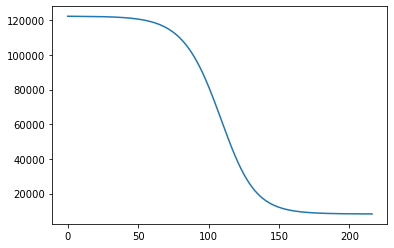

In [29]:
plt.plot(single_sim[0])

#### Fit the model

In [6]:
if True:#__name__ == '__main__':
    vars = [mortality_data, beta_1, beta_2, beta_h, sigma, mu, gamma, lice_index, 
            I1_0, I2_0, R_0, D_0, D_h,
            sus_frac,mortality, mortality_sim]
    
    mc = pm.MCMC(vars, db='pickle', dbname='ectoparasite')
    mc.use_step_method(pm.AdaptiveMetropolis, [beta_1, beta_2, sus_frac, I1_0])
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.sample(iter=180000, burn=80000, thin=10, verbose=0)
    mc.db.close()

 [                  0%                  ] 1194 of 180000 complete in 8.1 sec

/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/pymc/StepMethods.py:1282: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 180000 of 180000 complete in 351.0 sec

#### Output summary

In [5]:
pm.gelman_rubin(mc)

AttributeError: module 'pymc' has no attribute 'gelman_rubin'

In [15]:
mc.write_csv('tmp.csv')

In [7]:
M = pm.MAP(mc)
M.fit()
M.BIC

/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/home/adam/anaconda3/envs/jotpy/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/ho

10897.33813691938

#### Plot the posteriors

In [8]:
%matplotlib inline
plot(mc)

NameError: name 'plot' is not defined

#### Plot the fit

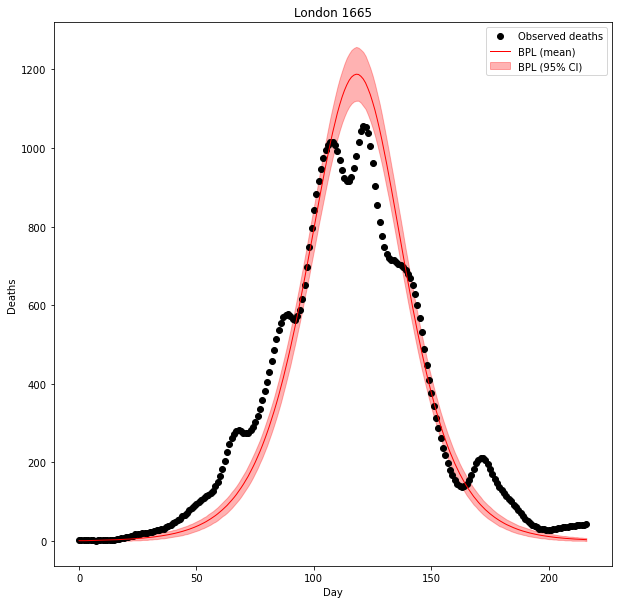

In [9]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title('London 1665')
plt.xlabel('Day')
plt.ylabel('Deaths')
plt.plot(mortality_data, 'o', mec='black', color='black', label='Observed deaths')
plt.plot(mortality_sim.stats()['mean'], color='red', linewidth=1, label='BPL (mean)')
y_min = mortality_sim.stats()['quantiles'][2.5]
y_max = mortality_sim.stats()['quantiles'][97.5]
plt.fill_between(range(0,len(mortality_data)), y_min, y_max, color='r', alpha=0.3, label='BPL (95% CI)')
plt.legend()
#plt.savefig('barcelona_1490_bpl.png')